# Section 3: Bayesian Time Series Models

#### PyData London 2025 - Bayesian Time Series Analysis with PyMC

---

In this section, we'll explore the landscape of Bayesian time series models, from simple random walks to sophisticated state-space models and Gaussian processes. These models provide the foundation for understanding temporal patterns and making probabilistic forecasts.

In [1]:
import numpy as np
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import warnings

az.style.use("arviz-darkgrid")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RNG = np.random.default_rng(RANDOM_SEED:=42)

print("🔧 Libraries loaded successfully!")


🔧 Libraries loaded successfully!


Our first motivating example will be the population dymanics of the arctic ground squirrel (*Urocitellus parryii*) in the Kluane region of the Yukon Territory, Canada. Typically, arctic hare get all the attention, with their cyclic population dynamics being a classic example of a predator-prey system. However, the arctic ground squirrel is a much more abundant species, and their population dynamics are also interesting.

![Arctic ground squirrel](images/Arctic-Ground-Squirrel.jpg)

Below are densities, estimated independently twice per year from mark-recapture data.

In [2]:
# Load data and filter for years up to 1999
squirrel_data = pl.read_csv('../data/arctic_ground_squirrels_timeseries.csv')

# Create plot data with both spring and summer for context
squirrel_plot = (squirrel_data
    .filter(pl.col('Average_per_ha').is_not_null())
    .filter(pl.col('Year') <= 1999)
    .sort(['Year', 'Season'])
    .with_columns([
        pl.when(pl.col('Season') == 'Spring')
        .then(pl.col('Year') + 0.25)
        .otherwise(pl.col('Year') + 0.5)
        .alias('Year_fractional')
    ])
)

In [3]:
# Create marker colors and symbols based on season
marker_colors = ['green' if season == 'Spring' else 'orange' for season in squirrel_plot['Season']]
marker_symbols = ['circle' if season == 'Spring' else 'square' for season in squirrel_plot['Season']]
hover_text = [f'<b>Year:</b> {year:.0f}<br><b>Season:</b> {season}<br><b>Density:</b> {density:.2f} per hectare<extra></extra>' 
              for year, season, density in zip(squirrel_plot['Year_fractional'], squirrel_plot['Season'], squirrel_plot['Average_per_ha'])]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=squirrel_plot['Year_fractional'],
    y=squirrel_plot['Average_per_ha'],
    mode='lines+markers',
    name='Population Density',
    line=dict(color='steelblue', width=2),
    marker=dict(
        size=8,
        color=marker_colors,
        symbol=marker_symbols
    ),
    text=squirrel_plot['Season'],
    hovertemplate=hover_text
))

fig.update_layout(
    title=dict(
        text='Arctic Ground Squirrel Population Density - Spring and Summer (1990-1999)',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    showlegend=False,
    template='plotly_white'
)

fig.add_annotation(
    x=0.02, y=0.98,
    xref='paper', yref='paper',
    text='🟢 Spring &nbsp;&nbsp; 🟠 Summer',
    showarrow=False,
    font=dict(size=12),
    bgcolor='rgba(255,255,255,0.8)',
    bordercolor='gray',
    borderwidth=1
)

fig.show()

## Random Walk Models

The regression model that we fit in the previous notebook assumes a linear relationship between predictor and response variables. This is a parametric regression - it uses just a few parameters (slope and intercept) to describe the entire relationship.

In contrast, **non-parametric models** use many parameters to flexibly adapt to the data's structure without imposing strong assumptions about functional form. They aren't actually without parameters; rather, the number of parameters varies with the quantity of data.

We'll demonstrate this flexibility using a random walk, where each observation depends only on the previous value plus random noise:

$$y_t = y_{t-1} + \epsilon_t$$

Here, $\epsilon_t$ represents the **innovation** or step size, which is drawn from a probability distribution at each time point $t$.

### Gaussian Random Walk

A **Gaussian Random Walk** is a specific flavor of random walk where the innovations are Gaussian, $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$.

This structure allows random walks to adapt to various trend patterns without imposing rigid functional forms. Moreover, the variance of the random walk is non-stationary, reflecting our decreasing confidence in long-term predictions. 

$\text{Var}(y_t) = t \cdot \sigma^2$

Let's implement a Gaussian random walk in PyMC to model the Arctic ground squirrel population data. To keep things simple, we will only model the summer population.

In [4]:
# Extract summer data only for modeling
squirrel_summer = (squirrel_data
    .filter(pl.col('Average_per_ha').is_not_null())
    .filter(pl.col('Season') == 'Summer')
    .filter(pl.col('Year') <= 1999)
    .sort('Year')
    .with_row_index('time_index')
)

# Model variables (summer data only)
squirrel_density = squirrel_summer['Average_per_ha'].to_numpy()
years = squirrel_summer['Year'].to_numpy().astype(int)
n_years = len(years)
time_idx = np.arange(n_years)
time_normalized = (time_idx - time_idx.mean()) / time_idx.std()

In [5]:
# Simple Random Walk for Ground Squirrel Summer Population
with pm.Model(coords={'time': years}) as simple_rw_model:

    y_obs = pm.Data('y_obs', squirrel_density, dims='time')
    
    # Step size of the random walk (innovation standard deviation)
    sigma_walk = pm.HalfNormal('sigma_walk', sigma=1.0)
    
    # Initial value distribution
    init_dist = pm.Normal.dist(mu=0, sigma=1)
    
    # Gaussian random walk process using dims
    log_walk = pm.GaussianRandomWalk('log_walk', 
        mu=0,  # no drift
        sigma=sigma_walk, 
        init_dist=init_dist,
        dims='time')
    
    walk = pm.Deterministic('walk', pm.math.exp(log_walk))
    
    # Observation noise (measurement error)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1.0)
    
    # Likelihood: observed squirrel density data are noisy observations of the walk
    y = pm.LogNormal('y', mu=log_walk, sigma=sigma_obs, observed=y_obs, dims='time')

In [6]:
with simple_rw_model:
    trace_simple_rw = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_walk, log_walk, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
print("🎯 **Simple Random Walk Results for Ground Squirrel Summer Population**:")
print(az.summary(trace_simple_rw, var_names=['sigma_walk', 'sigma_obs']))

🎯 **Simple Random Walk Results for Ground Squirrel Summer Population**:
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_walk  0.347  0.166   0.043    0.611      0.008    0.004     283.0   
sigma_obs   0.229  0.152   0.028    0.480      0.011    0.004     137.0   

            ess_tail  r_hat  
sigma_walk     183.0   1.01  
sigma_obs      145.0   1.03  


In [8]:
with simple_rw_model:
    pm.sample_posterior_predictive(trace_simple_rw, extend_inferencedata=True,
                                   random_seed=RANDOM_SEED)

Sampling: [y]


Output()

In [9]:
walk_samples = az.extract(trace_simple_rw)['walk']
y_samples = az.extract(trace_simple_rw, group='posterior_predictive')['y']

walk_mean = walk_samples.mean(dim='sample')
walk_hdi = az.hdi(trace_simple_rw, var_names=['walk'])['walk']

y_mean = y_samples.mean(dim='sample')
y_hdi = az.hdi(trace_simple_rw, group='posterior_predictive', var_names=['y'])['y']

go.Figure().add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([y_hdi[:, 1], y_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(144, 238, 144, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Posterior Predictive 95% HDI',
    showlegend=True
)).add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([walk_hdi[:, 1], walk_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Random Walk 95% HDI',
    showlegend=True
)).add_trace(go.Scatter(
    x=years,
    y=walk_mean,
    mode='lines',
    name='Estimated Random Walk',
    line=dict(color='darkgreen', width=3)
)).add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='red',
        symbol='circle',
        line=dict(width=2, color='darkred')
    )
)).update_layout(
    title=dict(
        text='Simple Random Walk Model - Arctic Ground Squirrel Summer Population',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

Notice that the estimated model does not pass directly through the observed points.

In our implementation, we separate the **latent random walk process** from the **observation process**, creating a state-space structure:

**State equation**: $x_t = x_{t-1} + \epsilon_t$ where $\epsilon_t \sim \mathcal{N}(0, \sigma_{\text{walk}}^2)$

**Observation equation**: $y_t = x_t + \nu_t$ where $\nu_t \sim \mathcal{N}(0, \sigma_{\text{obs}}^2)$

This separation allows us to distinguish between **process noise** (how much the underlying state changes) and **measurement noise** (how much error exists in our observations).

### Forecasting with Random Walk Models

One of the key advantages of Bayesian time series models is their ability to generate **probabilistic forecasts** that naturally quantify uncertainty. For random walk models, forecasting involves extending the stochastic process beyond the observed data.

**Mathematical Foundation of Random Walk Forecasting**:

For a random walk $y_t = y_{t-1} + \epsilon_t$ where $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$, the **h-step ahead forecast** from time $T$ is:

$$\hat{y}_{T+h|T} = y_T$$

The **forecast variance** grows linearly with the forecast horizon:

$$\text{Var}(y_{T+h|T}) = h \cdot \sigma^2$$

This means that:
- **Point forecasts** remain constant at the last observed value
- **Prediction intervals** widen linearly with time, reflecting increasing uncertainty
- **Long-term forecasts** become highly uncertain, which is realistic for many natural processes

Let's generate 10-year forecasts (2000-2009) for the Arctic ground squirrel population using parameters from our fitted random walk model.

In [10]:
# Generate a 10-year forecast
# Define forecast years (2000-2009)
forecast_years = np.arange(2000, 2010)
n_forecast = len(forecast_years)

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

# Extract posterior samples
posterior = az.extract(trace_simple_rw)
log_walk_samples = posterior['log_walk'].to_numpy()  
sigma_walk_samples = posterior['sigma_walk'].to_numpy()
sigma_obs_samples = posterior['sigma_obs'].to_numpy()

# Get the final state (1999) from each posterior sample
final_log_state_samples = log_walk_samples[-1, :]
n_samples = len(final_log_state_samples)

# Generate all random steps at once - shape: (n_samples, n_forecast)
random_steps = np.random.normal(
    loc=0, 
    scale=sigma_walk_samples[:, np.newaxis], 
    size=(n_samples, n_forecast)
)

# Create the random walks using cumulative sum
future_increments = np.cumsum(random_steps, axis=1)

# Add the final state to all increments to get the full trajectories (log means)
future_log_means = final_log_state_samples[:, np.newaxis] + future_increments

# Generate lognormal samples using vectorized operations
# First, generate standard normal samples
Z = np.random.normal(0, 1, size=(n_samples, n_forecast))

# Transform to lognormal using the formula: exp(mu + sigma * Z)
future_trajectories = np.exp(future_log_means + sigma_obs_samples[:, np.newaxis] * Z)

# Calculate forecast statistics
rw_forecast_median = np.median(future_trajectories, axis=0)
rw_forecast_hdi = az.hdi(future_trajectories, hdi_prob=0.95)
rw_forecast_lower = rw_forecast_hdi[:, 0]
rw_forecast_upper = rw_forecast_hdi[:, 1]

# Create the forecast plot
fig = go.Figure()

# Add original data points (1990-1999)
fig.add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='red',
        symbol='circle',
        line=dict(width=2, color='darkred')
    )
))

# Add median forecast line
fig.add_trace(go.Scatter(
    x=forecast_years,
    y=rw_forecast_median,
    mode='lines',
    name='Forecast Median',
    line=dict(color='blue', width=3)
))

# Add 95% HDI as a shaded region
fig.add_trace(go.Scatter(
    x=np.concatenate([forecast_years, forecast_years[::-1]]),
    y=np.concatenate([rw_forecast_upper, rw_forecast_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% HDI',
    showlegend=True
))

# Update layout
fig.update_layout(
    title=dict(
        text='10-Year Forecast for Arctic Ground Squirrel Summer Population (2000-2009)',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

# Ensure y-axis doesn't go below zero for population density
fig.update_yaxes(range=[0, None])

fig.show()

**Key Mathematical Properties**:

- **Stationarity condition**: $|\rho| < 1$ ensures the process is stationary
- **Mean**: $\mathbb{E}[y_t] = 0$ (assuming zero mean)
- **Variance**: $\text{Var}(y_t) = \frac{\sigma^2}{1 - \rho^2}$ (constant for stationary process)
- **Autocorrelation**: $\rho(k) = \rho^k$ (exponential decay)

**Interpretation of $\rho$**:
- $\rho > 0$: **Positive persistence** - high values tend to be followed by high values
- $\rho < 0$: **Oscillatory behavior** - high values tend to be followed by low values
- $\rho \approx 1$: **Near unit root** - very persistent, close to random walk behavior
- $\rho = 0$: **White noise** - no temporal dependence


### Interpreting Random Walk Forecasts

The forecast visualization reveals several key characteristics of random walk predictions:

**Forecast Behavior**:
- **Constant median prediction**: The forecast median remains approximately at the last observed value (though the mean is increasing)
- **Linearly increasing uncertainty**: The prediction intervals widen steadily over time, reflecting the accumulating uncertainty inherent in random walk processes
- **Realistic long-term uncertainty**: By 2009, the 95% HDI spans a wide range, acknowledging our limited ability to predict population levels a decade ahead

While the projections may not be terribly useful, it does at least provide a accurate reflection of its uncertainty, given the simplicity of the projection methodology. We probably need to incorporate covariates or other processes to improve the projections.

### Autoregressive Model AR(1)

**Autoregressive models** capture temporal dependence by relating current observations to past observations. An **AR(1) model** is defined as:

$$y_t = \phi y_{t-1} + \epsilon_t$$

where $\phi$ is the **autoregressive coefficient** and $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ is white noise.

A Gaussian random walk is a special case of an **autoregressive model**, where $\phi = 1$.

Now let's consider the more general case where $\rho$ varies.

In [11]:
# AR(1) for Ground Squirrel Summer Population
with pm.Model(coords={'time': years}) as ar1_model:

    y_obs = pm.Data('y_obs', squirrel_density, dims='time')
    
    sigma_ar = pm.HalfNormal('sigma_ar', sigma=1.0)

    rho = pm.Normal('rho', mu=0, sigma=1.0)
    
    init_dist = pm.Normal.dist(mu=0, sigma=1)
    
    # Gaussian random walk process using dims
    log_ar = pm.AR('log_ar', 
        rho=rho,
        sigma=sigma_ar,
        init_dist=init_dist,
        dims='time')
    
    ar = pm.Deterministic('ar', pm.math.exp(log_ar))
    
    # Observation noise (measurement error)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1.0)
    
    # Likelihood: observed squirrel density data are noisy observations of the walk
    y = pm.LogNormal('y', mu=log_ar, sigma=sigma_obs, observed=y_obs, dims='time')

In [12]:
with ar1_model:
    trace_ar1 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)
    pm.sample_posterior_predictive(trace_ar1, extend_inferencedata=True,
                                   random_seed=RANDOM_SEED)
    
print("🎯 **AR(1) Model Results for Ground Squirrel Population**:")
print(az.summary(trace_ar1, var_names=['rho', 'sigma_ar']))

# Extract and interpret AR coefficient
rho_mean = az.extract(trace_ar1)['rho'].mean().item()
rho_hdi = az.hdi(trace_ar1, var_names=['rho'])['rho']

print("\n📈 **Population Persistence Analysis**:")
print(f"   • **AR coefficient (φ)**: {rho_mean:.3f}")
print(f"   • **95% HDI**: [{rho_hdi.sel(hdi='lower').item():.3f}, {rho_hdi.sel(hdi='higher').item():.3f}]")
if rho_mean > 0.5:
    print("   • **Ecological interpretation**: High population persistence - good years tend to follow good years")
elif rho_mean < -0.5:
    print("   • **Ecological interpretation**: Population oscillations - good years tend to follow bad years")
else:
    print("   • **Ecological interpretation**: Moderate population memory - some year-to-year correlation")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_ar, rho, log_ar, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

🎯 **AR(1) Model Results for Ground Squirrel Population**:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
rho       0.316  0.443  -0.629    1.039      0.021    0.009     444.0   
sigma_ar  0.328  0.160   0.047    0.606      0.006    0.004     510.0   

          ess_tail  r_hat  
rho         1652.0   1.02  
sigma_ar     502.0   1.01  

📈 **Population Persistence Analysis**:
   • **AR coefficient (φ)**: 0.316
   • **95% HDI**: [-0.629, 1.039]
   • **Ecological interpretation**: Moderate population memory - some year-to-year correlation


**Key Mathematical Properties**:

- **Stationarity condition**: $|\rho| < 1$ ensures the process is stationary
- **Mean**: $\mathbb{E}[y_t] = 0$ (assuming zero mean)
- **Variance**: $\text{Var}(y_t) = \frac{\sigma^2}{1 - \rho^2}$ (constant for stationary process)
- **Autocorrelation**: $\rho(k) = \rho^k$ (exponential decay)

**Interpretation of $\rho$**:
- $\rho > 0$: **Positive persistence** - high values tend to be followed by high values
- $\rho < 0$: **Oscillatory behavior** - high values tend to be followed by low values
- $\rho \approx 1$: **Near unit root** - very persistent, close to random walk behavior
- $\rho = 0$: **White noise** - no temporal dependence


In [13]:
ar_samples = az.extract(trace_ar1)['ar']
y_samples = az.extract(trace_ar1, group='posterior_predictive')['y']

ar_mean = ar_samples.mean(dim='sample')
ar_hdi = az.hdi(trace_ar1, var_names=['ar'])['ar']

y_mean = y_samples.mean(dim='sample')
y_hdi = az.hdi(trace_ar1, group='posterior_predictive', var_names=['y'])['y']

go.Figure().add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([y_hdi[:, 1], y_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(144, 238, 144, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Posterior Predictive 95% HDI',
    showlegend=True
)).add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([walk_hdi[:, 1], walk_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Random Walk 95% HDI',
    showlegend=True
)).add_trace(go.Scatter(
    x=years,
    y=walk_mean,
    mode='lines',
    name='Estimated Density',
    line=dict(color='darkgreen', width=3)
)).add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='red',
        symbol='circle',
        line=dict(width=2, color='darkred')
    )
)).update_layout(
    title=dict(
        text='AR(1) Model - Arctic Ground Squirrel Summer Population',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

In [ ]:
# Create combined visualization comparing Random Walk and AR(2) models
fig = go.Figure()

# Add observed data points
fig.add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='black',
        symbol='circle'
    )
))

# Add Random Walk model mean prediction
fig.add_trace(go.Scatter(
    x=years,
    y=walk_mean,
    mode='lines',
    name='Random Walk Mean',
    line=dict(color='darkgreen', width=3)
))

# Add Random Walk model 95% HDI
fig.add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([walk_hdi[:, 1], walk_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Random Walk 95% HDI'
))

# Add AR(2) model mean prediction
ar_mean = az.extract(trace_ar2)['ar'].mean(dim='sample')
ar_hdi = az.hdi(trace_ar2, var_names=['ar'])['ar']

fig.add_trace(go.Scatter(
    x=years,
    y=ar_mean,
    mode='lines',
    name='AR(2) Mean',
    line=dict(color='darkblue', width=3)
))

# Add AR(2) model 95% HDI
fig.add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([ar_hdi[:, 1], ar_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(30, 144, 255, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='AR(2) 95% HDI'
))

# Update layout
fig.update_layout(
    title=dict(
        text='Model Comparison: Random Walk vs AR(2) for Squirrel Population',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

fig.show()

<Axes: title={'center': 'rho'}>

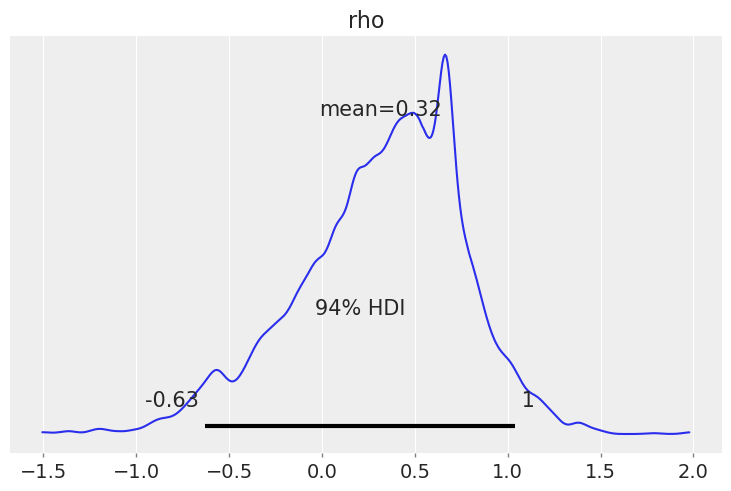

In [14]:
az.plot_posterior(trace_ar1, var_names=['rho'])

## Extending to AR(2) Models

While the AR(1) model provides a flexible generalization to the random walk, ecological systems often exhibit more complex dynamics that span multiple time periods. For example, an AR(2) model extends our analysis by incorporating dependencies on two previous time steps:

$$\log(y_t) = \rho_1 \cdot \log(y_{t-1}) + \rho_2 \cdot \log(y_{t-2}) + \epsilon_t$$

Where:
- $\rho_1$ represents the immediate persistence effect (as in AR(1))
- $\rho_2$ captures delayed effects from two time steps ago
- $\epsilon_t$ is the innovation term (random shock)

In the context of this data, AR(2) models can reveal important ecological patterns:

1. **Cyclical Dynamics**: Negative values of $\rho_2$ often indicate cyclical population fluctuations
2. **Delayed Density Dependence**: Effects of population size may take multiple years to manifest
3. **Complex Environmental Responses**: Populations may respond to environmental conditions with lag effects

Let's see how an AR(2) model performs on our squirrel data.

In [14]:
with pm.Model(coords={'time': years}) as ar2_model:

    y_obs = pm.Data('y_obs', squirrel_density, dims='time')
    
    sigma_ar = pm.HalfNormal('sigma_ar', sigma=1.0)

    rho = pm.Normal('rho', mu=0, sigma=1.0, shape=2)
    
    init_dist = pm.Normal.dist(mu=0, sigma=1)
    
    log_ar = pm.AR('log_ar', 
        rho=rho,
        sigma=sigma_ar,
        init_dist=init_dist,
        dims='time')
    
    ar = pm.Deterministic('ar', pm.math.exp(log_ar), dims='time')
    
    # Observation noise (measurement error)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1.0)
    
    # Likelihood: observed squirrel density data are noisy observations of the walk
    y = pm.LogNormal('y', mu=log_ar, sigma=sigma_obs, observed=y_obs, dims='time')

    trace_ar2 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_ar, rho, log_ar, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'rho\n0'}>,
       <Axes: title={'center': 'rho\n1'}>], dtype=object)

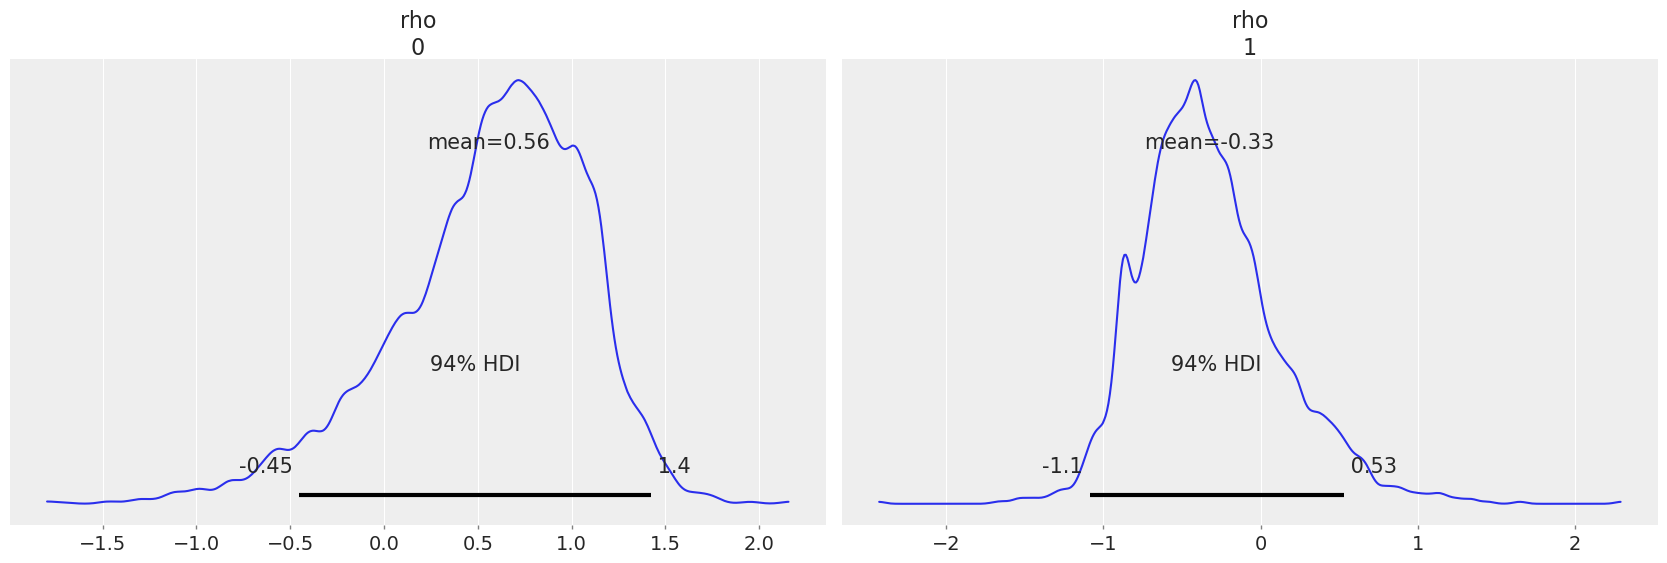

In [15]:
az.plot_posterior(trace_ar2, var_names=['rho'])

The estimated lag-2 autoregressive coefficient is probably negative, though it overlaps zero to some degree. This may be capturing a little of the cyclic behavior in the data.

Let's take this model and generate predictions, and compare them to what the population actually did post-2000.

In [20]:
# Generate a 10-year forecast
# Define forecast years (2000-2009)
forecast_years = np.arange(2000, 2010)
n_forecast = len(forecast_years)

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

# Create a new model for forecasting
with pm.Model(coords={'time': forecast_years}) as forecast_model:

    # Get parameters from the fitted model
    sigma_ar = pm.Flat('sigma_ar')
    rho = pm.Flat('rho', shape=2)
    sigma_obs = pm.Flat('sigma_obs')
    
    # Get the last two values from the fitted model to initialize the forecast
    log_ar_last = pm.Data('log_ar_last', trace_ar2.posterior['log_ar'].mean(dim=['chain', 'draw'])[-2:].values)
    
    # Create AR(2) process for the entire time period
    init_dist = pm.DiracDelta.dist(log_ar_last)
    log_ar = pm.AR('log_ar', rho=rho, sigma=sigma_ar, init_dist=init_dist, dims='time')
    
    # Transform to original scale
    ar = pm.math.exp(log_ar)
    
    # Likelihood for the observed period
    y = pm.LogNormal('y', mu=log_ar, sigma=sigma_obs, dims='time')

    
    # Sample from posterior predictive
    ar2_forecast_trace = pm.sample_posterior_predictive(
        trace_ar2, 
        var_names=['y'], 
        random_seed=RANDOM_SEED
    )

ar2_forecast_samples = ar2_forecast_trace.posterior_predictive['y'].stack(sample=("chain", "draw"))
ar2_forecast_median = ar2_forecast_samples.median(dim='sample').values

# Calculate HDI manually for each time point
ar2_forecast_lower = np.zeros(n_forecast)
ar2_forecast_upper = np.zeros(n_forecast)

# Get only the forecast period values (last n_forecast values
ar2_forecast_values = ar2_forecast_samples.values[-n_forecast:]

# Calculate HDI for each time point separately
for t in range(n_forecast):
    hdi = az.hdi(ar2_forecast_values[t], hdi_prob=0.95)
    ar2_forecast_lower[t] = hdi[0]
    ar2_forecast_upper[t] = hdi[1]

# Extract actual observations for the forecast period (summer only)
actual_future = (squirrel_data
    .filter((pl.col('Year') >= 2000) & (pl.col('Year') <= 2009) & (pl.col('Season') == 'Summer'))
    .sort('Year')
)
actual_years = actual_future['Year'].to_numpy()
actual_density = actual_future['Average_per_ha'].to_numpy()

# Create the forecast plot
fig = go.Figure()

# Add original data points (1990-1999)
fig.add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='red',
        symbol='circle',
        line=dict(width=2, color='darkred')
    )
))

# Add test data points (2000-2009)
# fig.add_trace(go.Scatter(
#     x=actual_years,
#     y=actual_density,
#     mode='markers',
#     name='Test Data',
#     marker=dict(
#         size=8,
#         color='green',
#         symbol='circle',
#         line=dict(width=2, color='darkgreen')
#     )
# ))

# Add median forecast line
fig.add_trace(go.Scatter(
    x=forecast_years,
    y=ar2_forecast_median[-n_forecast:],
    mode='lines',
    name='Forecast Median',
    line=dict(color='blue', width=3)
))

# Add 95% HDI as a shaded region
fig.add_trace(go.Scatter(
    x=np.concatenate([forecast_years, forecast_years[::-1]]),
    y=np.concatenate([ar2_forecast_upper, ar2_forecast_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% HDI',
    showlegend=True
))

# Update layout
fig.update_layout(
    title=dict(
        text='10-Year Forecast for Arctic Ground Squirrel Summer Population (2000-2009)',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

# Ensure y-axis doesn't go below zero for population density
fig.update_yaxes(range=[0, None])

fig.show()

Sampling: [log_ar, y]


Output()

In [19]:
# Generate a 10-year forecast
# Define forecast years (2000-2009)
forecast_years = np.arange(2000, 2010)
n_forecast = len(forecast_years)

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

# Create a new model for forecasting
with pm.Model(coords={'time': forecast_years}) as forecast_model:

    # Get parameters from the fitted model
    sigma_ar = pm.Flat('sigma_ar')
    rho = pm.Flat('rho', shape=2)
    sigma_obs = pm.Flat('sigma_obs')
    
    # Get the last two values from the fitted model to initialize the forecast
    log_ar_last = pm.Data('log_ar_last', trace_ar2.posterior['log_ar'].mean(dim=['chain', 'draw'])[-2:].values)
    
    # Create AR(2) process for the entire time period
    init_dist = pm.DiracDelta.dist(log_ar_last)
    log_ar = pm.AR('log_ar', rho=rho, sigma=sigma_ar, init_dist=init_dist, dims='time')
    
    # Transform to original scale
    ar = pm.math.exp(log_ar)
    
    # Likelihood for the observed period
    y = pm.LogNormal('y', mu=log_ar, sigma=sigma_obs, dims='time')

    
    # Sample from posterior predictive
    ar2_forecast_trace = pm.sample_posterior_predictive(
        trace_ar2, 
        var_names=['y'], 
        random_seed=RANDOM_SEED
    )

ar2_forecast_samples = ar2_forecast_trace.posterior_predictive['y'].stack(sample=("chain", "draw"))
ar2_forecast_median = ar2_forecast_samples.median(dim='sample').values

# Calculate HDI manually for each time point
ar2_forecast_lower = np.zeros(n_forecast)
ar2_forecast_upper = np.zeros(n_forecast)

# Get only the forecast period values (last n_forecast values
ar2_forecast_values = ar2_forecast_samples.values[-n_forecast:]

# Calculate HDI for each time point separately
for t in range(n_forecast):
    hdi = az.hdi(ar2_forecast_values[t], hdi_prob=0.95)
    ar2_forecast_lower[t] = hdi[0]
    ar2_forecast_upper[t] = hdi[1]

# Extract actual observations for the forecast period (summer only)
actual_future = (squirrel_data
    .filter((pl.col('Year') >= 2000) & (pl.col('Year') <= 2009) & (pl.col('Season') == 'Summer'))
    .sort('Year')
)
actual_years = actual_future['Year'].to_numpy()
actual_density = actual_future['Average_per_ha'].to_numpy()

# Create the forecast plot
fig = go.Figure()

# Add original data points (1990-1999)
fig.add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='red',
        symbol='circle',
        line=dict(width=2, color='darkred')
    )
))

# Add test data points (2000-2009)
# Add test data points (2000-2009) - hidden by default but toggleable
fig.add_trace(go.Scatter(
    x=actual_years,
    y=actual_density,
    mode='markers',
    name='Test Data',
    marker=dict(
        size=8,
        color='green',
        symbol='circle',
        line=dict(width=2, color='darkgreen')
    ),
    visible='legendonly'  # Hidden by default, can be toggled via legend
))

# Add AR(2) median forecast line
fig.add_trace(go.Scatter(
    x=forecast_years,
    y=ar2_forecast_median[-n_forecast:],
    mode='lines',
    name='AR(2) Forecast',
    line=dict(color='blue', width=3)
))

# Add AR(2) 95% HDI as a shaded region
fig.add_trace(go.Scatter(
    x=np.concatenate([forecast_years, forecast_years[::-1]]),
    y=np.concatenate([ar2_forecast_upper, ar2_forecast_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='AR(2) 95% HDI',
    showlegend=True
))

# Add Random Walk median forecast line
fig.add_trace(go.Scatter(
    x=forecast_years,
    y=rw_forecast_median,
    mode='lines',
    name='Random Walk Forecast',
    line=dict(color='purple', width=3, dash='dash')
))

# Add Random Walk 95% HDI as a shaded region
fig.add_trace(go.Scatter(
    x=np.concatenate([forecast_years, forecast_years[::-1]]),
    y=np.concatenate([rw_forecast_upper, rw_forecast_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(128, 0, 128, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Random Walk 95% HDI',
    showlegend=True
))

# Update layout
fig.update_layout(
    title=dict(
        text='10-Year Forecast Comparison: AR(2) vs Random Walk (2000-2009)',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

# Ensure y-axis doesn't go below zero for population density
fig.update_yaxes(range=[0, None])

fig.show()

Sampling: [log_ar, y]


Output()

### Seasonal Components with Fourier Terms

**Fourier terms** provide an elegant way to model seasonal patterns using trigonometric functions. For a time series with period $P$, we can represent seasonal patterns as:

$$s_t = \sum_{k=1}^{K} \left[ \beta_{s,k} \sin\left(\frac{2\pi k t}{P}\right) + \beta_{c,k} \cos\left(\frac{2\pi k t}{P}\right) \right]$$

where:
- $P$ is the **seasonal period** (e.g., 12 for monthly data with annual seasonality)
- $K$ is the **number of harmonics** (typically $K \leq P/2$)
- $\beta_{s,k}, \beta_{c,k}$ are the **Fourier coefficients**

**Mathematical properties**:
- **Periodicity**: $s_{t+P} = s_t$ for all $t$
- **Orthogonality**: Different harmonics are orthogonal over complete periods
- **Amplitude**: $A_k = \sqrt{\beta_{s,k}^2 + \beta_{c,k}^2}$ for harmonic $k$
- **Phase**: $\phi_k = \arctan(\beta_{s,k}/\beta_{c,k})$ for harmonic $k$

**Advantages of Fourier representation**:
- **Flexibility**: Can approximate any periodic function
- **Parsimony**: Few parameters can capture complex seasonal patterns
- **Interpretability**: Each harmonic represents a specific frequency component
- **Computational efficiency**: Fast evaluation and differentiation

**Harmonic interpretation**:
- **First harmonic** ($k=1$): Fundamental seasonal cycle
- **Second harmonic** ($k=2$): Half-period cycles (e.g., bi-annual patterns)
- **Higher harmonics**: Capture finer seasonal details and asymmetries

The complete model combines trend and seasonality:
$$y_t = \alpha + \beta t + s_t + \epsilon_t$$

In [ ]:
# Trend + Seasonality with Fourier Terms
# Create seasonal components (annual cycle for monthly data)
period = 12  # Monthly data with annual seasonality
seasonal_freq = 2 * np.pi / period
sin_seasonal = np.sin(seasonal_freq * time_idx)
cos_seasonal = np.cos(seasonal_freq * time_idx)

# Add second harmonic for more flexible seasonality
sin_seasonal_2 = np.sin(2 * seasonal_freq * time_idx)
cos_seasonal_2 = np.cos(2 * seasonal_freq * time_idx)

with pm.Model() as seasonal_model:
    # Intercept
    mu_overall = pm.Normal('mu_overall', mu=0, sigma=1)
    
    # Trend coefficient
    beta_trend = pm.Normal('beta_trend', mu=0, sigma=1)
    
    # First harmonic seasonal coefficients
    beta_sin_1 = pm.Normal('beta_sin_1', mu=0, sigma=1)
    beta_cos_1 = pm.Normal('beta_cos_1', mu=0, sigma=1)
    
    # Second harmonic seasonal coefficients
    beta_sin_2 = pm.Normal('beta_sin_2', mu=0, sigma=0.5)
    beta_cos_2 = pm.Normal('beta_cos_2', mu=0, sigma=0.5)
    
    # Expected value (trend + seasonality)
    mu_t = pm.Deterministic('mu_t', 
                           mu_overall + 
                           beta_trend * time_normalized + 
                           beta_sin_1 * sin_seasonal + 
                           beta_cos_1 * cos_seasonal +
                           beta_sin_2 * sin_seasonal_2 + 
                           beta_cos_2 * cos_seasonal_2)
    
    # Observation noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu_t, sigma=sigma_obs, observed=births_standardized)

# Sample from seasonal model
with seasonal_model:
    trace_seasonal = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

print("🎯 **Seasonal Model Results**:")
print(az.summary(trace_seasonal, var_names=['mu_overall', 'beta_trend', 'beta_sin_1', 'beta_cos_1', 'sigma_obs']))

# Calculate seasonal amplitude
beta_sin_1_mean = az.extract(trace_seasonal)['beta_sin_1'].mean().item()
beta_cos_1_mean = az.extract(trace_seasonal)['beta_cos_1'].mean().item()
seasonal_amplitude = np.sqrt(beta_sin_1_mean**2 + beta_cos_1_mean**2)

print(f"\n📈 **Seasonal Analysis**:")
print(f"   • **Seasonal amplitude**: {seasonal_amplitude:.3f}")
print(f"   • **Seasonal strength**: {seasonal_amplitude / births_standardized.std():.1%} of total variation")
if seasonal_amplitude > 0.2:
    print(f"   • **Interpretation**: Strong seasonal pattern detected")
else:
    print(f"   • **Interpretation**: Weak seasonal pattern")

## Part 3: State-Space Models in PyMC

State-space models represent one of the most powerful frameworks for time series analysis. They separate the **latent state** (unobserved process) from the **observation process** (what we actually measure), enabling sophisticated modeling of complex temporal dynamics.

### Mathematical Framework

State-space models consist of two equations:

**State equation** (evolution): $x_t = f(x_{t-1}, \theta) + \eta_t$

**Observation equation** (measurement): $y_t = g(x_t, \phi) + \epsilon_t$

where $x_t$ represents the **latent state**, $y_t$ is the **observation**, $\eta_t$ and $\epsilon_t$ are **noise terms**, and $\theta, \phi$ are **parameters**.

### Advantages of State-Space Modeling

**Latent variable modeling** allows us to separate the true underlying process from measurement noise and observation errors. **Missing data handling** becomes natural since we can estimate latent states even when observations are missing. **Hierarchical structure** enables modeling of complex relationships between multiple time series. **Uncertainty propagation** flows naturally through the state evolution, providing realistic prediction intervals.

### Local Level Model (Dynamic Linear Model)

The **local level model** is the simplest state-space model, consisting of two equations:

**State equation**: $\mu_t = \mu_{t-1} + \eta_t$ where $\eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$

**Observation equation**: $y_t = \mu_t + \epsilon_t$ where $\epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$

where:
- $\mu_t$ is the **latent level** (unobserved state)
- $\eta_t$ is the **state innovation** (level changes)
- $\epsilon_t$ is the **observation noise** (measurement error)
- $\sigma_{\eta}^2$ controls **state variability**
- $\sigma_{\epsilon}^2$ controls **observation noise**

**Key properties**:
- **Signal-to-noise ratio**: $q = \sigma_{\eta}^2 / \sigma_{\epsilon}^2$ determines smoothness
- **High $q$**: Flexible tracking of level changes (noisy estimates)
- **Low $q$**: Smooth level estimates (slow adaptation)
- **Kalman filtering**: Optimal recursive estimation of latent states

**Applications**:
- **Trend extraction** from noisy economic indicators
- **Signal processing** in engineering applications
- **Baseline estimation** for anomaly detection
- **Missing data interpolation** using state estimates

This model excels at **trend estimation** and **signal extraction** from noisy data while naturally handling missing observations.

In [ ]:
# Local Level Model (State-Space)
with pm.Model() as local_level_model:
    # Process noise (state evolution variance)
    sigma_level = pm.HalfNormal('sigma_level', sigma=0.5)
    
    # Observation noise (measurement error variance)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.5)
    
    # Initial level
    init_level = pm.Normal('init_level', mu=0, sigma=1)
    
    # Level process (latent state - random walk)
    init_dist = pm.Normal.dist(mu=init_level, sigma=sigma_level)
    level = pm.GaussianRandomWalk('level',
                                 mu=0,  # no drift in level
                                 sigma=sigma_level,
                                 init_dist=init_dist,
                                 steps=n_obs-1)
    
    # Observations (noisy measurements of latent state)
    obs = pm.Normal('obs', mu=level, sigma=sigma_obs, observed=births_standardized)

# Sample from local level model
with local_level_model:
    trace_local_level = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

print("🎯 **Local Level Model Results**:")
print(az.summary(trace_local_level, var_names=['sigma_level', 'sigma_obs', 'init_level']))

# Analyze signal-to-noise ratio
sigma_level_mean = az.extract(trace_local_level)['sigma_level'].mean().item()
sigma_obs_mean = az.extract(trace_local_level)['sigma_obs'].mean().item()
signal_noise_ratio = sigma_level_mean / sigma_obs_mean

print(f"\n📈 **State-Space Analysis**:")
print(f"   • **Process noise**: {sigma_level_mean:.3f} - latent state variability")
print(f"   • **Observation noise**: {sigma_obs_mean:.3f} - measurement error")
print(f"   • **Signal-to-noise ratio**: {signal_noise_ratio:.3f}")
if signal_noise_ratio > 1:
    print(f"   • **Interpretation**: High signal relative to noise - clear underlying trend")
else:
    print(f"   • **Interpretation**: High noise relative to signal - noisy measurements")

### Local Linear Trend Model

The **local linear trend model** extends the local level model by adding a **time-varying slope** component. This model consists of three equations:

**Level equation**: $\mu_t = \mu_{t-1} + \beta_{t-1} + \eta_{\mu,t}$ where $\eta_{\mu,t} \sim \mathcal{N}(0, \sigma_{\mu}^2)$

**Trend equation**: $\beta_t = \beta_{t-1} + \eta_{\beta,t}$ where $\eta_{\beta,t} \sim \mathcal{N}(0, \sigma_{\beta}^2)$

**Observation equation**: $y_t = \mu_t + \epsilon_t$ where $\epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$

where:
- $\mu_t$ is the **time-varying level**
- $\beta_t$ is the **time-varying slope** (trend)
- $\eta_{\mu,t}$ is the **level innovation**
- $\eta_{\beta,t}$ is the **slope innovation**
- $\epsilon_t$ is the **observation noise**

**Key features**:
- **Adaptive trending**: The slope can change over time
- **Smooth evolution**: Both level and slope follow random walks
- **Flexible growth**: Can model accelerating, decelerating, or changing direction
- **Parameter interpretation**: $\sigma_{\beta}^2$ controls how much the growth rate varies

**Special cases**:
- $\sigma_{\beta}^2 = 0$: **Constant slope** (reduces to linear trend)
- $\sigma_{\mu}^2 = 0$: **Deterministic level** given trend
- $\sigma_{\beta}^2 \gg \sigma_{\mu}^2$: **Highly variable growth rates**

This model allows both the level and the trend to evolve over time, providing greater flexibility for modeling changing growth rates in economic, demographic, or technological time series.

In [ ]:
# Local Linear Trend Model
with pm.Model() as local_trend_model:
    # Process noise variances
    sigma_level = pm.HalfNormal('sigma_level', sigma=0.3)  # level innovation
    sigma_trend = pm.HalfNormal('sigma_trend', sigma=0.1)  # trend innovation
    
    # Observation noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.5)
    
    # Initial conditions
    init_level = pm.Normal('init_level', mu=0, sigma=1)
    init_trend = pm.Normal('init_trend', mu=0, sigma=0.1)
    
    # Trend process (random walk)
    trend_init_dist = pm.Normal.dist(mu=init_trend, sigma=sigma_trend)
    trend = pm.GaussianRandomWalk('trend',
                                 mu=0,
                                 sigma=sigma_trend,
                                 init_dist=trend_init_dist,
                                 steps=n_obs-1)
    
    # Level process (random walk + trend)
    # This is more complex - we'll use a simpler approximation
    level_innovation = pm.Normal('level_innovation', mu=0, sigma=sigma_level, shape=n_obs)
    
    # Construct level with trend
    level = pm.Deterministic('level', 
                            pt.cumsum(pt.concatenate([[init_level], 
                                                     trend + level_innovation[1:]])))
    
    # Observations
    obs = pm.Normal('obs', mu=level, sigma=sigma_obs, observed=births_standardized)

# Sample from local trend model
with local_trend_model:
    trace_local_trend = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

print("🎯 **Local Linear Trend Model Results**:")
print(az.summary(trace_local_trend, var_names=['sigma_level', 'sigma_trend', 'sigma_obs']))

# Analyze trend variability
sigma_trend_mean = az.extract(trace_local_trend)['sigma_trend'].mean().item()
print(f"\n📈 **Trend Dynamics Analysis**:")
print(f"   • **Trend variability**: {sigma_trend_mean:.4f}")
if sigma_trend_mean > 0.05:
    print(f"   • **Interpretation**: Highly variable trend - changing growth rates")
else:
    print(f"   • **Interpretation**: Stable trend - consistent growth pattern")

## Part 4: Stochastic Volatility Models

**Stochastic volatility models** address the reality that uncertainty itself changes over time. These models are essential for financial time series where periods of calm alternate with periods of high volatility, but they're also valuable for any time series where the variability changes systematically.

### Mathematical Framework

The standard stochastic volatility model consists of:

**Returns equation**: $r_t = \mu + \sigma_t \epsilon_t$

**Volatility equation**: $\log(\sigma_t^2) = \log(\sigma_{t-1}^2) + \nu_t$

where $\epsilon_t, \nu_t \sim \mathcal{N}(0,1)$ are **independent innovations**.

### Applications Beyond Finance

While originally developed for financial markets, stochastic volatility models apply to many domains. **Environmental data** often shows changing variability due to seasonal effects or climate change. **Economic indicators** may have periods of stability and instability. **Biological processes** can exhibit changing variance due to external stressors or developmental stages.

In [ ]:
# Generate synthetic data with time-varying volatility for demonstration
np.random.seed(42)
n_periods = 200
true_mu = 0.02
true_tau = 0.1

# Simulate log-volatility as random walk
log_vol = np.cumsum(np.random.normal(0, true_tau, n_periods))
vol = np.exp(log_vol / 2)

# Simulate returns with time-varying volatility
returns = np.random.normal(true_mu, vol)

print(f"📈 Generated {n_periods} synthetic returns with stochastic volatility")
print(f"   Mean return: {returns.mean():.4f}")
print(f"   Return volatility: {returns.std():.4f}")
print(f"   Volatility range: [{vol.min():.3f}, {vol.max():.3f}]")

### Stochastic Volatility Model

**Stochastic volatility models** capture **time-varying uncertainty** by allowing the variance to follow its own stochastic process. The standard specification is:

**Returns equation**: $r_t = \mu + \sigma_t \epsilon_t$ where $\epsilon_t \sim \mathcal{N}(0, 1)$

**Log-volatility equation**: $\log(\sigma_t) = \log(\sigma_{t-1}) + \nu_t$ where $\nu_t \sim \mathcal{N}(0, \tau^2)$

where:
- $r_t$ are the **returns** (or observations)
- $\mu$ is the **mean return**
- $\sigma_t$ is the **time-varying volatility**
- $\tau^2$ controls the **volatility of volatility**
- $\epsilon_t, \nu_t$ are **independent** innovations

**Mathematical properties**:
- **Log-normal volatility**: $\sigma_t$ is always positive
- **Volatility clustering**: High volatility periods tend to persist
- **Heavy tails**: Returns distribution has fatter tails than normal
- **Leverage effect**: Can be extended to include correlation between return and volatility shocks

**Parameter interpretation**:
- **Large $\tau$**: Highly variable volatility (regime switching)
- **Small $\tau$**: Stable volatility (close to constant variance)
- **Persistence**: $\mathbb{E}[\log(\sigma_{t+1}) | \log(\sigma_t)] = \log(\sigma_t)$ (unit root in log-volatility)

**Applications beyond finance**:
- **Environmental data**: Changing measurement precision
- **Economic indicators**: Periods of stability vs. uncertainty
- **Biological processes**: Variable response to treatments
- **Engineering systems**: Time-varying noise characteristics

In [ ]:
# Stochastic Volatility Model
with pm.Model() as stoch_vol_model:
    # Mean return parameter
    mu = pm.Normal('mu', mu=0, sigma=0.1)
    
    # Volatility process parameters
    tau = pm.HalfNormal('tau', sigma=0.2)  # Innovation in log-volatility
    
    # Log-volatility random walk
    init_dist = pm.Normal.dist(mu=np.log(0.1), sigma=1)
    log_sigma = pm.GaussianRandomWalk('log_sigma',
                                     mu=0,
                                     sigma=tau,
                                     init_dist=init_dist,
                                     steps=n_periods-1)
    
    # Convert to volatility (ensure positivity)
    sigma = pm.Deterministic('sigma', pm.math.exp(log_sigma))
    
    # Likelihood (returns with time-varying volatility)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=returns)

# Sample from stochastic volatility model
with stoch_vol_model:
    trace_sv = pm.sample(1000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

print("🎯 **Stochastic Volatility Model Results**:")
print(az.summary(trace_sv, var_names=['mu', 'tau']))

# Analyze volatility dynamics
tau_mean = az.extract(trace_sv)['tau'].mean().item()
sigma_posterior = az.extract(trace_sv)['sigma']
vol_persistence = np.corrcoef(sigma_posterior[:-1], sigma_posterior[1:])[0,1]

print(f"\n📈 **Volatility Analysis**:")
print(f"   • **Volatility innovation**: {tau_mean:.4f}")
print(f"   • **Volatility persistence**: {vol_persistence:.3f}")
print(f"   • **Mean volatility**: {sigma_posterior.mean():.3f}")
if tau_mean > 0.1:
    print(f"   • **Interpretation**: Highly variable volatility - regime changes")
else:
    print(f"   • **Interpretation**: Stable volatility - gradual changes")

## Part 5: Gaussian Process Regression for Time Series

**Gaussian Processes (GPs)** provide the ultimate flexibility in time series modeling by learning the temporal structure directly from data without imposing strong parametric assumptions. They excel when the functional form is unknown or when we want to capture complex, non-linear patterns.

### Key Concepts

**Covariance functions** (kernels) define the relationship between points in time, encoding our assumptions about smoothness, periodicity, and other structural properties. **Length scales** control how quickly correlations decay with time separation. **Marginal variance** controls the overall variability of the process. **Hyperparameter learning** allows the model to adapt these properties to the data.

### Advantages of GP Modeling

**Non-parametric flexibility** means we don't need to specify a particular functional form in advance. **Uncertainty quantification** is built-in, providing credible intervals that naturally widen in regions with less data. **Kernel composition** allows combining different temporal patterns (trends, seasonality, noise) in principled ways. **Extrapolation** provides reasonable predictions beyond the training data with appropriate uncertainty.

In [ ]:
# Prepare data for GP regression (use subset for computational efficiency)
n_gp = 100
X_gp = np.arange(n_gp)[:, None]  # Time points (must be 2D for GP)
y_gp = births_standardized[:n_gp]  # Observations

print(f"📊 GP data prepared: {n_gp} observations")
print(f"   Time range: 0 to {n_gp-1}")
print(f"   Data range: [{y_gp.min():.3f}, {y_gp.max():.3f}]")

### Gaussian Process with RBF Kernel

We'll start with a **Radial Basis Function (RBF)** kernel, also known as the squared exponential kernel. The RBF kernel is defined as:

$$k(t_i, t_j) = \sigma_f^2 \exp\left(-\frac{(t_i - t_j)^2}{2\ell^2}\right)$$

where:
- $\sigma_f^2$ is the **signal variance** (marginal variance)
- $\ell$ is the **length scale** (correlation distance)
- $t_i, t_j$ are **time points**

**Mathematical properties**:
- **Smoothness**: Infinitely differentiable (very smooth functions)
- **Stationarity**: Covariance depends only on $|t_i - t_j|$
- **Isotropy**: Same behavior in all directions
- **Decay**: Correlation decreases exponentially with distance

**Hyperparameter interpretation**:
- **Large $\ell$**: Long-range correlations, smooth trends
- **Small $\ell$**: Short-range correlations, rapid changes
- **Large $\sigma_f^2$**: High signal variance, large deviations from mean
- **Small $\sigma_f^2$**: Low signal variance, stays close to mean

The complete GP model includes observation noise:
$$y_t = f(t) + \epsilon_t$$
where $f(t) \sim \mathcal{GP}(0, k(t_i, t_j))$ and $\epsilon_t \sim \mathcal{N}(0, \sigma_n^2)$.

This kernel assumes smooth, continuous functions and is excellent for capturing non-linear trends without sharp discontinuities.

In [ ]:
# Gaussian Process with RBF Kernel
with pm.Model() as gp_model:
    # GP hyperparameters
    length_scale = pm.HalfNormal('length_scale', sigma=10.0)  # temporal correlation
    eta = pm.HalfNormal('eta', sigma=1.0)  # marginal standard deviation
    
    # Define the covariance function (RBF/Squared Exponential)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=length_scale)
    
    # GP prior
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    # Observation noise
    sigma_gp = pm.HalfNormal('sigma_gp', sigma=0.5)
    
    # Observed data
    y_pred = gp.marginal_likelihood('y_pred', X=X_gp, y=y_gp, sigma=sigma_gp)

# Sample from the model
with gp_model:
    trace_gp = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

print("🎯 **Gaussian Process Model Results**:")
print(az.summary(trace_gp, var_names=['length_scale', 'eta', 'sigma_gp']))

# Interpret GP hyperparameters
length_scale_mean = az.extract(trace_gp)['length_scale'].mean().item()
eta_mean = az.extract(trace_gp)['eta'].mean().item()
sigma_gp_mean = az.extract(trace_gp)['sigma_gp'].mean().item()

print(f"\n📈 **GP Analysis**:")
print(f"   • **Length scale**: {length_scale_mean:.2f} time units")
print(f"   • **Signal variance**: {eta_mean:.3f}")
print(f"   • **Noise variance**: {sigma_gp_mean:.3f}")
print(f"   • **Signal-to-noise ratio**: {eta_mean/sigma_gp_mean:.2f}")
if length_scale_mean > 20:
    print(f"   • **Interpretation**: Long-range correlations - smooth trends")
elif length_scale_mean > 5:
    print(f"   • **Interpretation**: Medium-range correlations - moderate smoothness")
else:
    print(f"   • **Interpretation**: Short-range correlations - rapid changes")

## Model Comparison and Selection

With multiple models fitted to our data, we need principled methods for comparing their performance and selecting the most appropriate approach. **Bayesian model comparison** provides several tools for this purpose, each with different strengths and applications.

In [ ]:
# Compare models using WAIC (Widely Applicable Information Criterion)
# Note: We'll compare models that use the same data
models_dict = {
    'Random Walk': trace_rw,
    'RW with Drift': trace_rw_drift,
    'AR(1)': trace_ar1,
    'Linear Trend': trace_linear,
    'Polynomial Trend': trace_poly,
    'Seasonal Model': trace_seasonal,
    'Local Level': trace_local_level
}

# Compute WAIC for model comparison
comparison = az.compare(models_dict, ic='waic')
print("🎯 **Model Comparison Results (WAIC)**:")
print(comparison)

# Visualize model comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot WAIC comparison
az.plot_compare(comparison, ax=ax1)
ax1.set_title('Model Comparison: WAIC Scores')

# Plot model weights
model_names = comparison.index
weights = comparison['weight']
ax2.bar(range(len(model_names)), weights, color='steelblue', alpha=0.7)
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.set_ylabel('Model Weight')
ax2.set_title('Model Weights (Probability)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpret results
best_model = comparison.index[0]
best_weight = comparison.loc[best_model, 'weight']

print(f"\n📊 **Model Selection Insights**:")
print(f"   • **Best model**: {best_model} (weight: {best_weight:.3f})")
print(f"   • **WAIC interpretation**: Lower values indicate better predictive performance")
print(f"   • **Model weights**: Represent relative probability of each model")
if best_weight > 0.5:
    print(f"   • **Conclusion**: Strong evidence favors the {best_model} model")
else:
    print(f"   • **Conclusion**: Model uncertainty - consider ensemble approaches")

## Summary and Key Insights

In this comprehensive section, we've explored the rich landscape of Bayesian time series models, from fundamental building blocks to sophisticated state-space and non-parametric approaches. Each model type offers unique advantages and is suited to different types of temporal patterns and modeling objectives.

### Model Categories and Applications

**Gaussian Random Walks** serve as the foundation for many time series models, providing smooth trend estimation and natural uncertainty propagation. These models excel when we need to capture gradual changes over time without imposing rigid functional forms. The ability to add drift terms makes them suitable for trending data, while their computational efficiency makes them practical for large datasets.

**Bayesian Regression Models** offer maximum interpretability by explicitly modeling trend and seasonal components. The linear trend model provides a baseline for understanding directional movement, while polynomial extensions capture more complex curvature patterns. Fourier-based seasonal models elegantly handle periodic patterns and can accommodate multiple seasonal frequencies simultaneously.

**State-Space Models** represent the most flexible framework for separating latent dynamics from observation processes. The local level model excels at signal extraction from noisy data, while local linear trend models capture time-varying growth rates. These models naturally handle missing data and provide a foundation for more complex hierarchical structures.

**Stochastic Volatility Models** address the crucial reality that uncertainty itself changes over time. While originally developed for financial applications, these models apply broadly to any domain where variability patterns are of interest. They provide insights into regime changes and help identify periods of stability versus instability.

**Gaussian Process Models** offer ultimate flexibility by learning temporal structure directly from data. Their non-parametric nature makes them ideal for exploratory analysis and situations where the functional form is unknown. The ability to compose kernels allows for sophisticated modeling of multiple temporal patterns simultaneously.

### Practical Modeling Guidelines

**Start simple** and build complexity gradually. Random walks and linear trends provide excellent baselines that often perform surprisingly well. **Consider the data characteristics** when choosing models—trending data benefits from drift terms or explicit trend modeling, while seasonal data requires appropriate periodic components.

**Use domain knowledge** to guide model selection and prior specification. Understanding the underlying process generating your data helps choose appropriate model structures and realistic parameter ranges. **Validate thoroughly** using posterior predictive checks and out-of-sample evaluation to ensure models capture essential patterns without overfitting.

**Embrace uncertainty** in model selection. When multiple models perform similarly, consider ensemble approaches that average across models weighted by their posterior probabilities. This approach often provides more robust predictions than relying on a single "best" model.

### Computational Considerations

**Model complexity** directly impacts computational requirements. Simple models like random walks and linear regression scale well to large datasets, while Gaussian processes become computationally intensive for more than a few hundred observations. **Prior specification** significantly affects convergence—weakly informative priors often provide the best balance between regularization and flexibility.

**Convergence diagnostics** remain crucial regardless of model complexity. Always examine R-hat values, effective sample sizes, and trace plots to ensure reliable inference. **Computational efficiency** can often be improved through data standardization, appropriate parameterizations, and careful prior choices.

**Next**: In the following sections, we'll explore model evaluation techniques, forecasting methods, and practical applications that build upon these foundational modeling approaches.

---

**Key Takeaways**:
- Bayesian time series modeling offers a rich toolkit for capturing temporal patterns while quantifying uncertainty
- Random walks provide flexible trend modeling, regression approaches offer interpretable component decomposition
- State-space models separate signal from noise, stochastic volatility captures changing uncertainty
- Gaussian processes provide non-parametric flexibility for complex temporal patterns
- Model selection should balance complexity with interpretability, always validated through rigorous posterior checking and out-of-sample evaluation
- The Bayesian framework naturally handles uncertainty in both parameters and model structure, providing robust foundations for forecasting and decision-making under uncertainty